# Installs and Imports

In [ ]:
# !pip install pyvista
# !pip install matplotlib

In [1]:
import dolfinx
import numpy as np
import json
from mpi4py import MPI
from dolfinx.cpp.mesh import CellType
import ufl
from math import sin, cos, pi
import itertools
from operator import itemgetter
from matplotlib import pyplot as plt

# FEM Code Functions

In [2]:
FEM_OBJS_LIST = ['mesh', 'u', 'v', 'ds', 'bc', 'T']
FEM_FIXEDPARAM_KEYS = ["W", "L", "el_order"]

def create_fem_objs(elem_size, fixed_params):
    
    # Unpack fixed_params:
    W, L, elem_order = itemgetter(*FEM_FIXEDPARAM_KEYS)(fixed_params)

    # Compute number of elements along width and length:
    NL, NW = round(L/elem_size), round(W/elem_size)
    
    num_elem = NL*NW*NW
    
    mesh = dolfinx.BoxMesh(MPI.COMM_WORLD, [np.array([0,0,0]), np.array([L, W, W])], [NL,NW,NW], cell_type=CellType.tetrahedron)
    V = dolfinx.VectorFunctionSpace(mesh, ("CG", elem_order))

    clamped_boundary = lambda x: np.isclose(x[0], 0)

    fdim = mesh.topology.dim - 1
    boundary_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, clamped_boundary)

    u_D = dolfinx.Function(V)
    with u_D.vector.localForm() as loc:
        loc.set(0)
    bc = dolfinx.DirichletBC(u_D, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

    T = dolfinx.Constant(mesh, (0, 0, 0))

    ds = ufl.Measure("ds", domain=mesh)

    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    
    fem_params = {key : val for (key, val) in zip(FEM_OBJS_LIST, (mesh, u, v, ds, bc, T))}
    
    return (fem_params, num_elem)

In [3]:
LOADING_FIXEDPARAM_KEYS = ['rho', 'g']

def perform_loading(E, beam_angle, fixed_params, fem_objects):
    
    # Convert angle to radians:
    beam_angle *= pi/180
    
    # Unpack fixed params:
    rho, g = itemgetter(*LOADING_FIXEDPARAM_KEYS)(fixed_params)
    
    # Unpack fem objects:
    mesh, u, v, ds, bc, T = itemgetter(*FEM_OBJS_LIST)(fem_objects)
    
    # Compute Lame parameters:
    mu = E/(2*(1 + nu))
    lambda_ = E*nu/((1 + nu)*(1 - 2*nu))
            
    # Define variational problem:
    epsilon = lambda u: ufl.sym(ufl.grad(u))
    sigma = lambda u: lambda_ * ufl.nabla_div(u) * ufl.Identity(u.geometric_dimension()) + 2*mu*epsilon(u)
    a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
    f = dolfinx.Constant(mesh, (rho*g*cos(beam_angle), 0, -rho*g*sin(beam_angle)))
    L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds
    problem = dolfinx.fem.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_atol":1e-3, "ksp_rtol":1e-3, "ksp_type": "preonly", "pc_type": "lu"})
    
    problem._solver.setTolerances(rtol=1e-3, atol=1e-3, divtol=1e-3)
    
    # problem._solver.rtol = 1e-3
    # problem._solver.atol = 1e-3
    
    # Solve problem:
    u = problem.solve()
    u_vals = u.compute_point_values().real
    
    return u_vals

# Mesh Convergence

In [4]:
def mesh_convergence(num_elem_list, E, beam_angle, fixed_params):
    
    # Extract length and width of beam
    L, W = fixed_params['L'], fixed_params['W']
    
    # Compute beam volume:
    beam_vol = L*W**2
    
    # Initialise list to store results:
    results_dict = {'End Displacement':[], 'Number of Elements':[], 'Element Size':[]}
    
    # Iterate over all mesh elements to explore 
    for i, num_elem in enumerate(num_elem_list):
        print(f'Simulating Mesh {i+1}/{len(num_elem_list)} (Number of elements = {num_elem})')
        
        # Compute size of elements:
        elem_size = (beam_vol/num_elem)**(1/3)
        results_dict['Element Size'].append(elem_size)
        
        # First, create 'fixed' parameters of model:
        fem_objects, true_num_elem = create_fem_objs(elem_size, fixed_params)
        results_dict['Number of Elements'].append(true_num_elem)
        
        # Performing loading:
        u_vals = perform_loading(E, beam_angle, fixed_params, fem_objects)
        
        # Get displacement at end of beam:
        idx_2_get = np.isclose(fem_objects['mesh'].geometry.x, [fixed_params['L'], fixed_params['W'], fixed_params['W']])
        idx_2_get = np.where(np.all(idx_2_get, axis=1))
        disp_vals = np.sum(u_vals**2, axis=1)**(1/2)
        results_dict['End Displacement'].append(disp_vals[idx_2_get].item())
        print(f'End disp = {disp_vals[idx_2_get]}')
    
    # Also store fixed parameters with results:
    results_dict['E'] = E
    results_dict['Beam Angle'] = beam_angle
    results_dict.update(fixed_params)
    
    return results_dict

In [5]:
# Material constants:
nu = 0.33 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2

# Beam dimensions:
W = 40 # in mm
L = 90 # in mm

# FEM parameters:
el_order = 2

# Store parameters in dictionary:
fixed_params = {"nu":nu, "rho":rho, "g":g, "el_order":el_order, "L":L, "W":W}

# Define stiffness and beam angle to perform convergence study for:
E = 10
beam_angle = 90

# Define number of elements to check:
num_elem_list = [100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
    
# Create results dictionary:
convergence_results = mesh_convergence(num_elem_list, E, beam_angle, fixed_params)

# Save dictionary to JSON file:
save_name = "linear_convergence.json"
with open('./'+save_name, 'w') as f:
    json.dump(convergence_results, f, indent=4)

Simulating Mesh 1/11 (Number of elements = 100)
End disp = [72.89]
Simulating Mesh 2/11 (Number of elements = 250)
End disp = [73.17]
Simulating Mesh 3/11 (Number of elements = 500)
End disp = [73.31]
Simulating Mesh 4/11 (Number of elements = 750)
End disp = [73.38]
Simulating Mesh 5/11 (Number of elements = 1000)
End disp = [73.42]
Simulating Mesh 6/11 (Number of elements = 1500)
End disp = [73.47]
Simulating Mesh 7/11 (Number of elements = 2000)
End disp = [73.5]
Simulating Mesh 8/11 (Number of elements = 2500)
End disp = [73.51]
Simulating Mesh 9/11 (Number of elements = 3000)
End disp = [73.53]
Simulating Mesh 10/11 (Number of elements = 3500)
End disp = [73.54]
Simulating Mesh 11/11 (Number of elements = 4000)
End disp = [73.55]


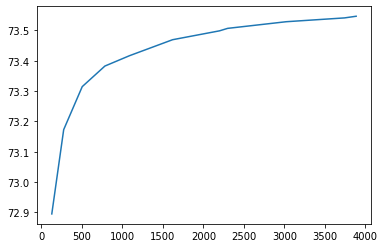

In [6]:
# Mesh convergence plot:
plt.plot(convergence_results['Number of Elements'], convergence_results['End Displacement'])

From above plot, looks like 3000 elements should be more than enough.

# Generate Data

In [4]:
def create_param_combos(param_list):
    keys = param_list.keys()
    param_combos = []
    for bundle in itertools.product(*param_list.values()):
        param_dict = dict(zip(keys, bundle))
        param_combos.append(param_dict)
    return param_combos

In [5]:
def create_data(params_dict, num_elem, fixed_params): 
    
    # Extract length and width of beam
    L, W = fixed_params['L'], fixed_params['W']
    
    # Compute beam volume:
    beam_vol = L*W**2
    
    # Compute size of elements:
    elem_size = (beam_vol/num_elem)**(1/3)
    
    # Generate FEM objects - these won't change between simulations:
    fem_objects, true_num_elem = create_fem_objs(elem_size, fixed_params)
    
    # Compute index of node to get displacement from:
    idx_2_get = np.isclose(fem_objects['mesh'].geometry.x, [fixed_params['L'], fixed_params['W'], fixed_params['W']])
    idx_2_get = np.where(np.all(idx_2_get, axis=1))
    
    # Generate all possible combinations of training data parameters:
    param_combos = create_param_combos(params_dict)
    results_dict = {'E':[], 'Beam Angle':[], 'End Displacement':[]}
    
    for i, params in enumerate(param_combos):
        print(f"Computing data point {i+1}/{len(param_combos)}")
        results_dict['E'].append(params['E'])            
        results_dict['Beam Angle'].append(params['angle']) 
        u_val = perform_loading(params['E'], params['angle'], fixed_params, fem_objects)
        disp = np.sum(u_val**2, axis=1)**(1/2)               
        results_dict['End Displacement'].append(disp[idx_2_get].item())
                                
    # Store fixed parameters and element size in this dictionary as well:
    results_dict["Element size"] = elem_size
    results_dict["Number of Elements"] = true_num_elem
    results_dict.update(fixed_params)
    
    return results_dict

In [6]:
# Define set of fixed parameters:
nu = 0.33 # dimensionless
rho = 0.00102 # in g mm^-3
g = 9.81 # in m s^-2
W = 40 # in mm
L = 90 # in mm
el_order = 2
fixed_params = {"nu":nu, "rho":rho, "g":g, "el_order":el_order, "L":L, "W":W}

# Define number of elements:
num_elem = 2500

In [7]:
# First create training data:
num_pts = 10
min_E, max_E = 10, 40
min_ang, max_ang = 0, 180
train_params = {'E': np.linspace(min_E, max_E, num_pts),
                'angle': np.linspace(min_ang, max_ang, num_pts)}

training_dict = create_data(train_params, num_elem, fixed_params)

# Save dictionary to JSON file:
save_name = "linear_train.json"
with open('./'+save_name, 'w') as f:
    json.dump(training_dict, f, indent=4)

Computing data point 1/100
Computing data point 2/100
Computing data point 3/100
Computing data point 4/100
Computing data point 5/100
Computing data point 6/100
Computing data point 7/100
Computing data point 8/100
Computing data point 9/100
Computing data point 10/100
Computing data point 11/100
Computing data point 12/100
Computing data point 13/100
Computing data point 14/100
Computing data point 15/100
Computing data point 16/100
Computing data point 17/100
Computing data point 18/100
Computing data point 19/100
Computing data point 20/100
Computing data point 21/100
Computing data point 22/100
Computing data point 23/100
Computing data point 24/100
Computing data point 25/100
Computing data point 26/100
Computing data point 27/100
Computing data point 28/100
Computing data point 29/100
Computing data point 30/100
Computing data point 31/100
Computing data point 32/100
Computing data point 33/100
Computing data point 34/100
Computing data point 35/100
Computing data point 36/100
C

In [8]:
# Next create test data:
delta_E = (max_E-min_E)/(num_pts-1)
delta_ang = (max_ang-min_ang)/(num_pts-1)
E_test = [E for E in np.linspace(min_E+0.5*delta_E, max_E-0.5*delta_E, num_pts-1)]
angle_test = [angle for angle in np.linspace(min_ang+0.5*delta_ang, max_ang-0.5*delta_ang, num_pts-1)]
test_params = {"E": E_test, "angle": angle_test}

test_dict = create_data(test_params, num_elem, fixed_params)

# Save dictionary to JSON file:
save_name = "linear_test.json"
with open('./'+save_name, 'w') as f:
    json.dump(test_dict, f, indent=4)

Computing data point 1/81
Computing data point 2/81
Computing data point 3/81
Computing data point 4/81
Computing data point 5/81
Computing data point 6/81
Computing data point 7/81
Computing data point 8/81
Computing data point 9/81
Computing data point 10/81
Computing data point 11/81
Computing data point 12/81
Computing data point 13/81
Computing data point 14/81


IOStream.flush timed out


Computing data point 15/81
Computing data point 16/81


IOStream.flush timed out


Computing data point 17/81
Computing data point 18/81
Computing data point 19/81
Computing data point 20/81
Computing data point 21/81
Computing data point 22/81
Computing data point 23/81
Computing data point 24/81
Computing data point 25/81
Computing data point 26/81
Computing data point 27/81
Computing data point 28/81
Computing data point 29/81
Computing data point 30/81
Computing data point 31/81
Computing data point 32/81
Computing data point 33/81
Computing data point 34/81
Computing data point 35/81
Computing data point 36/81
Computing data point 37/81
Computing data point 38/81
Computing data point 39/81
Computing data point 40/81
Computing data point 41/81
Computing data point 42/81
Computing data point 43/81
Computing data point 44/81
Computing data point 45/81
Computing data point 46/81
Computing data point 47/81
Computing data point 48/81
Computing data point 49/81
Computing data point 50/81
Computing data point 51/81
Computing data point 52/81
Computing data point 53/81
C

# Plot Data

In [12]:
# Let's plot the training and test data:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

mpl.rcParams['figure.dpi'] = 300

def plot_data(data, grid_shape, num_levels, E_lims=None, angle_lims=None, y_lims=None):

    angle, E, y = np.array(data['Beam Angle']), np.array(data['E']), np.array(data['End Displacement'])
    
    levels = np.linspace(y_lims[0], y_lims[1], num_levels)
    
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(E.reshape(grid_shape), angle.reshape(grid_shape), y.reshape(grid_shape), 
                              levels=levels, cmap=cm.coolwarm)
    
    ticks = np.array(range(y_lims[0], y_lims[1]+1, 20))
    cbar = fig.colorbar(contour_fig, ticks=ticks)
    cbar.set_label('Displacement', rotation=270, labelpad=15)
    ax.set_xlabel('Beam Elasticity E')
    ax.set_ylabel('Angle of Beam in Degrees')
    ax.set_xlim(E_lims)
    ax.set_ylim(angle_lims)
    plt.plot(E, angle, 'x', color='black', markersize=6)
    fig.patch.set_facecolor('white')
    plt.show()

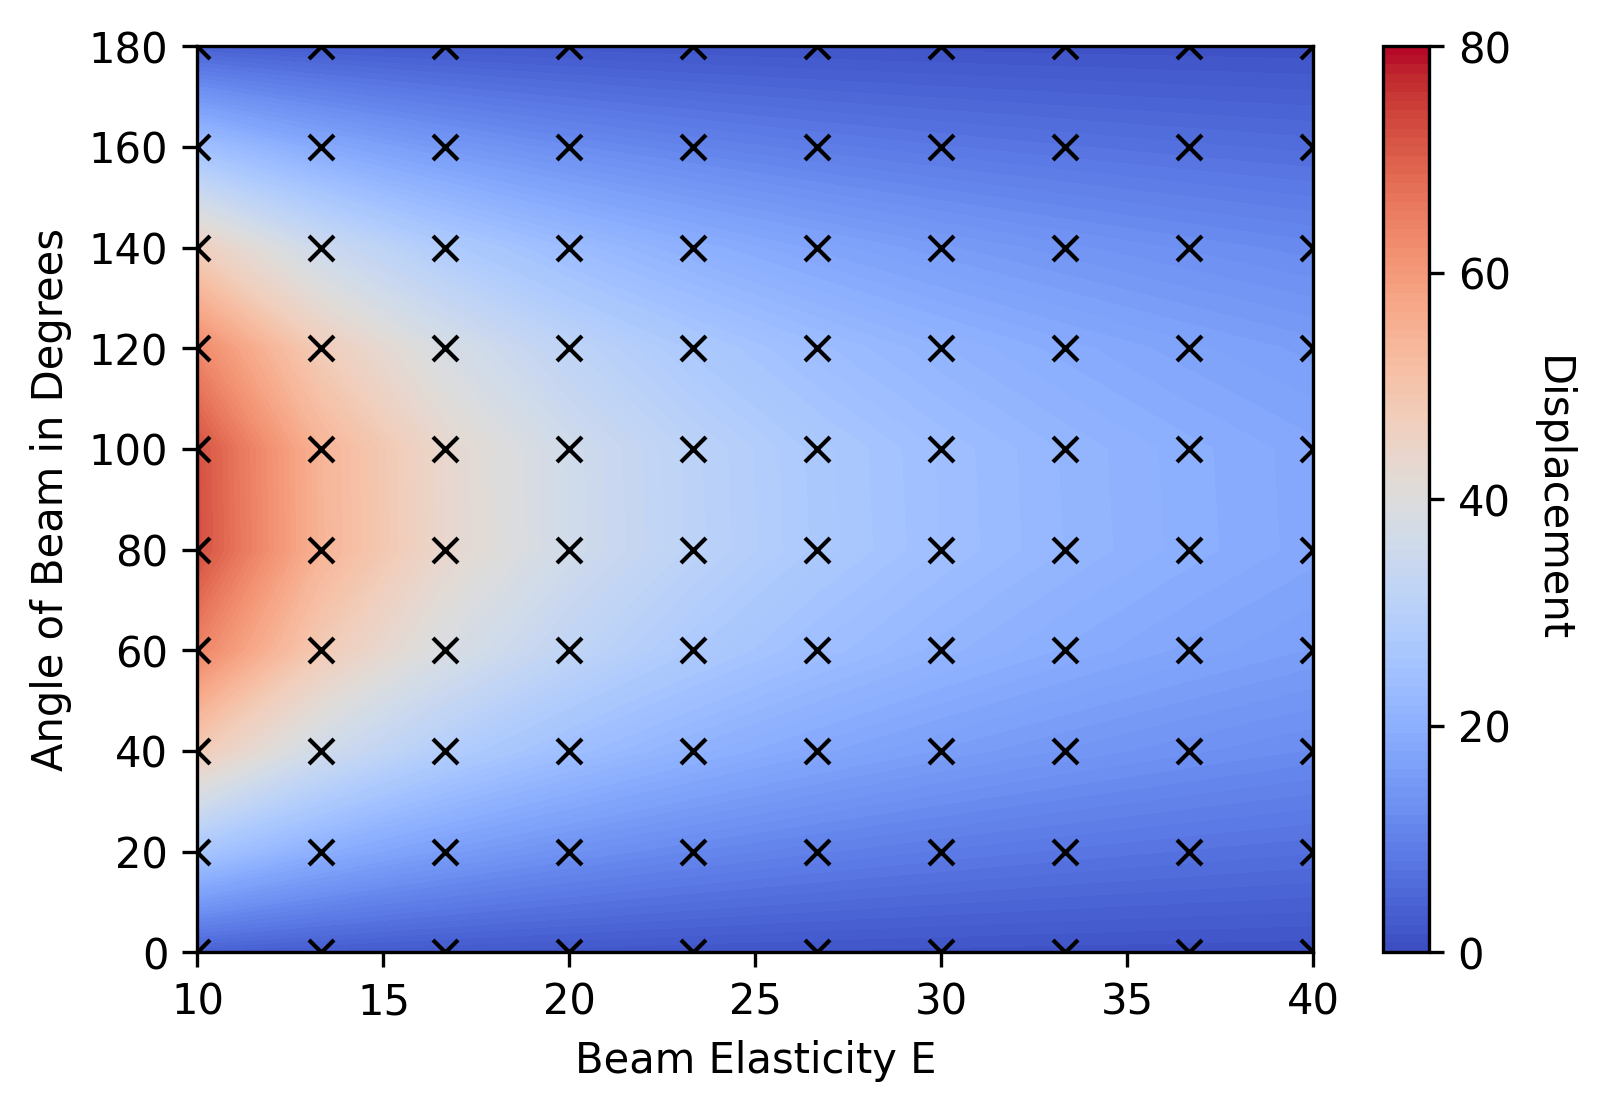

In [14]:
with open('linear_train.json', 'r') as f:
    training_dict = json.load(f)

y_lims = [0, 80]
E_lims = [10, 40]
angle_lims = [0, 180]
grid_shape = (10, 10)
num_levels = 100
plot_data(training_dict, grid_shape, num_levels, E_lims, angle_lims, y_lims)

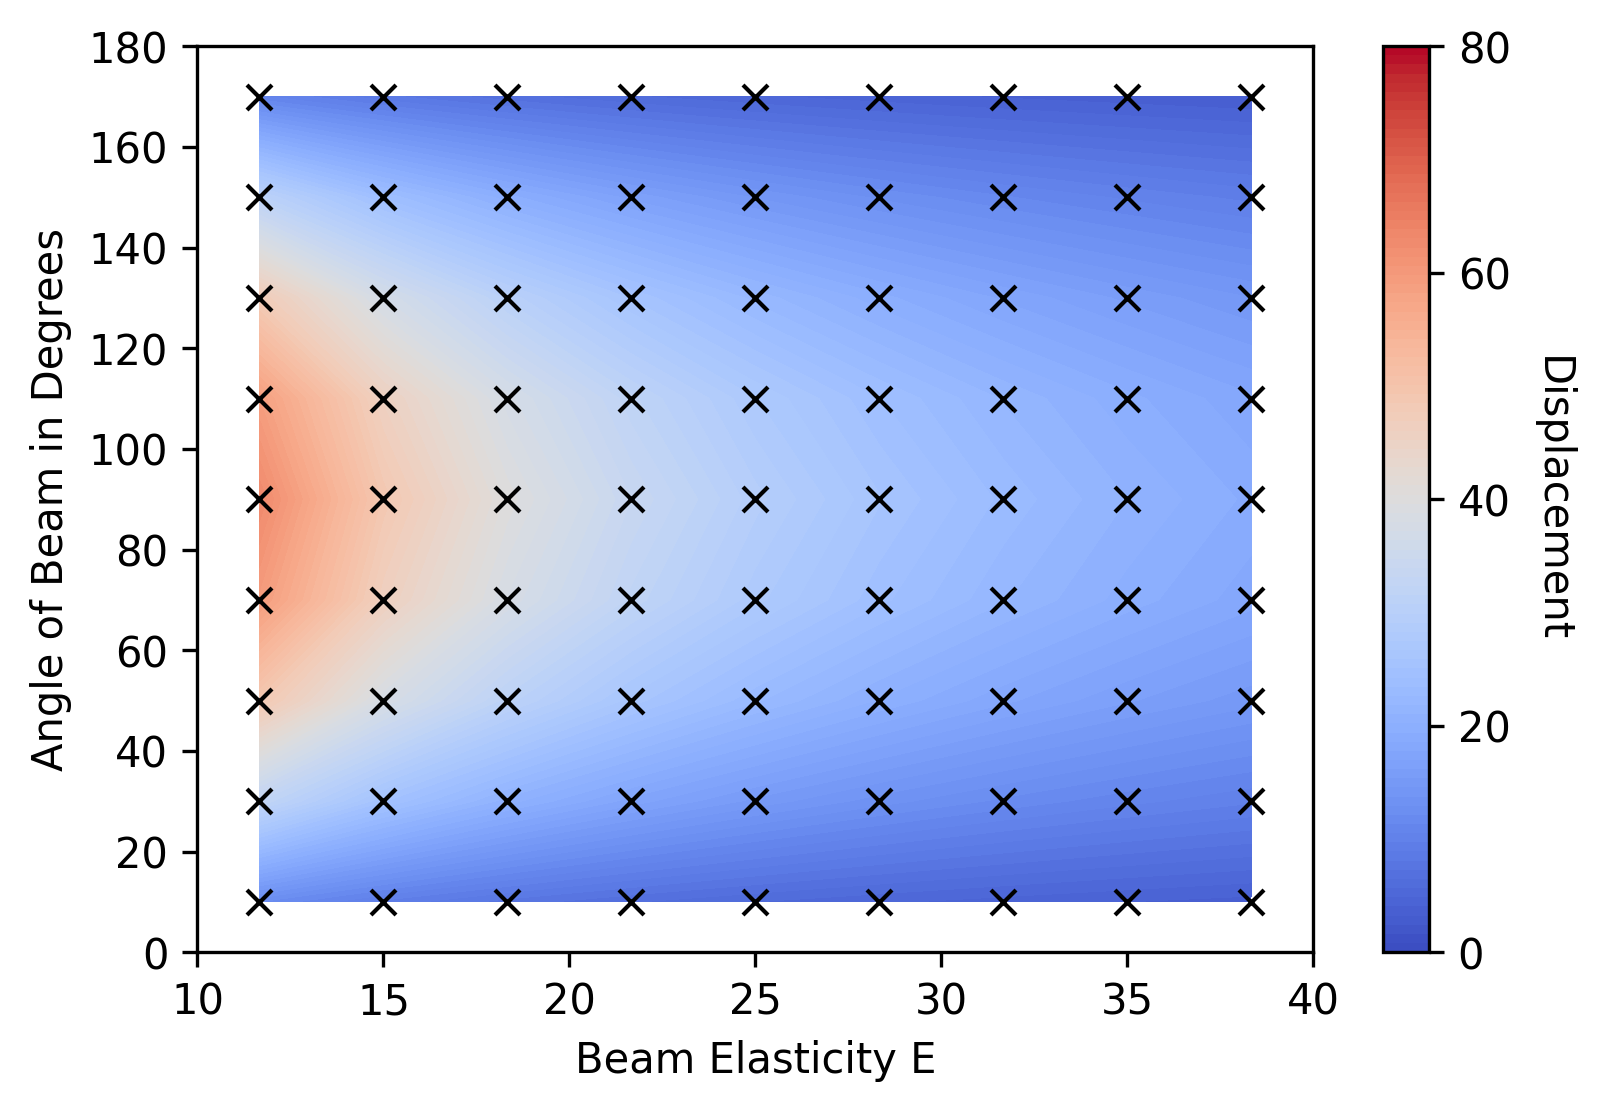

In [15]:
with open('linear_test.json', 'r') as f:
    test_dict = json.load(f)

y_lims = [0, 80]
E_lims = [10, 40]
angle_lims = [0, 180]
grid_shape = (9, 9)
num_levels = 100
plot_data(test_dict, grid_shape, num_levels, E_lims, angle_lims, y_lims)